# 환경준비

In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

# 자체제작 함수 준비

In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d) : 
    # 컬럼이름 리스트를 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace('social_',''))



# 향후 OLS모델에 쓸지도...
def formula_gen(deg, df):
    func = "qty ~ "
    for i in range(deg):
        if i ==0:
            prefix =""
        else:
            prefix = " + "
        func += prefix + "I(temp**{})".format(i+1)
    model = sm.OLS.from_formula(func, data=df)
    return model


# modeling 함수로 만들어 처리하기
def linReg(df, item):
    col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
                 ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
    X = df.loc[df['category']==item,col_to_use]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item):
    col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
                 ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
    X = df.loc[df['category']==item,col_to_use]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item):
    col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
                 ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
    X = df.loc[df['category']==item,col_to_use]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )

# 데이터 불러오기

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lavla = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
weather = pd.read_csv('d:/project/contest/data/processed/p_weather.csv', parse_dates=['date'])
social_all = pd.read_csv('D:/project/contest/data/processed/social_all.csv',parse_dates=['date'])

In [4]:
seoul_gu = list(gs[['pvn_nm','bor_nm']].loc[(gs['pvn_nm']=='서울특별시'),'bor_nm'].unique())
print(seoul_gu)

['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']


# 일단 서울

In [5]:
# d_ : gs/랄라블라 데이터
# w_ : 날씨 데이터
# s_ : 소셜데이터로 칭하겠음.
# 예1) dw_어쩌구 = 판매데이터+날씨 데이터
# 예2) dws_어쩌구 = 판매데이터+날씨+소셜 데이터
# 예3) ds_어쩌구 = 판매데이터+소셜 데이터
# 하는 방식으로 정의 하겠음.

# gs 판매데이터+날씨

d_cols_using = ['date','gender','age_cd','category','qty','nth_week']
d_gs = gs.loc[(gs['pvn_nm']=='서울특별시'),d_cols_using]

w_cols_using = ['date','temp', 'humid', 'wind', 'rain', 'snow','cloud','sun_time']
w_seoul = weather.loc[weather['loc']==108,w_cols_using]

dw_gs = d_gs.merge(w_seoul, on='date',how='left')
# dw_gs.tail(1)

# 랄라블라 판매데이터+날씨
d_lavla = lavla.loc[(lavla['pvn_nm']=='서울특별시'),d_cols_using]

dw_lavla = d_lavla.merge(w_seoul, on='date',how='left')

In [7]:
# 한꺼번에 처리하기위해 소셜 데이터셋 리스트 생성
collections = [social_all]

# 혹시 모를 실수 대비, 복사떠서 작업
dws_gs = dw_gs.copy()
dws_lavla = dw_lavla.copy()

for df in collections:
#     print(df.columns[1])
    dws_gs = dws_gs.merge(df, on='date',how='left')
    dws_lavla = dws_lavla.merge(df, on='date',how='left')
print('dws_gs 컬럼명 : ',dws_gs.columns)
print('dws_lavla 컬럼명 : ',dws_lavla.columns)

dws_gs 컬럼명 :  Index(['date', 'gender', 'age_cd', 'category', 'qty', 'nth_week', 'temp',
       'humid', 'wind', 'rain', 'snow', 'cloud', 'sun_time', 'pm.blog',
       'pm.twitter', 'pm.news', 'pm.total', 'health.blog', 'health.twitter',
       'health.news', 'health.total', 'date.blog', 'date.twitter', 'date.news',
       'date.total', 'br.blog', 'br.twitter', 'br.news', 'br.total',
       'hobby.blog', 'hobby.twitter', 'hobby.news', 'hobby.total'],
      dtype='object')
dws_lavla 컬럼명 :  Index(['date', 'gender', 'age_cd', 'category', 'qty', 'nth_week', 'temp',
       'humid', 'wind', 'rain', 'snow', 'cloud', 'sun_time', 'pm.blog',
       'pm.twitter', 'pm.news', 'pm.total', 'health.blog', 'health.twitter',
       'health.news', 'health.total', 'date.blog', 'date.twitter', 'date.news',
       'date.total', 'br.blog', 'br.twitter', 'br.news', 'br.total',
       'hobby.blog', 'hobby.twitter', 'hobby.news', 'hobby.total'],
      dtype='object')


In [ ]:
# #저장
# ds_gs = dws_gs[['date','gender', 'category', 'qty', 'nth_week','pm.blog',
#        'pm.twitter', 'pm.news', 'pm.total', 'health.blog', 'health.twitter',
#        'health.news', 'health.total', 'date.blog', 'date.twitter', 'date.news',
#        'date.total', 'br.blog', 'br.twitter', 'br.news', 'br.total',
#        'hobby.blog', 'hobby.twitter', 'hobby.news', 'hobby.total']]
# ds_lv = dws_lavla[['date','gender', 'category', 'qty', 'nth_week','pm.blog',
#        'pm.twitter', 'pm.news', 'pm.total', 'health.blog', 'health.twitter',
#        'health.news', 'health.total', 'date.blog', 'date.twitter', 'date.news',
#        'date.total', 'br.blog', 'br.twitter', 'br.news', 'br.total',
#        'hobby.blog', 'hobby.twitter', 'hobby.news', 'hobby.total']]
# print('dws_gs 컬럼명 : ',ds_gs.columns)
# print('dws_lavla 컬럼명 : ',ds_lv.columns)
# ds_gs.to_csv('D:/project/contest/data/processed/gs_social.csv',encoding='utf-8', index=False)
# ds_lv.to_csv('D:/project/contest/data/processed/lv_social.csv',encoding='utf-8', index=False)

#### 데이터 전처리 완

In [8]:
gs_category = list(d_gs['category'].unique())
lavla_category = list(d_lavla['category'].unique())
print(gs_category)
print(lavla_category)

['라면', '과자', '마스크', '맥주', '생리대', '생수', '숙취해소제', '스타킹', '아이스크림', '탄산음료', '면도기', '우산']
['립컬러', '립케어', '마스크팩', '바디로션', '체중조절', '크림로션', '훼이셜클렌저', '선케어', '네일', '제모제']


##### 분석 시작

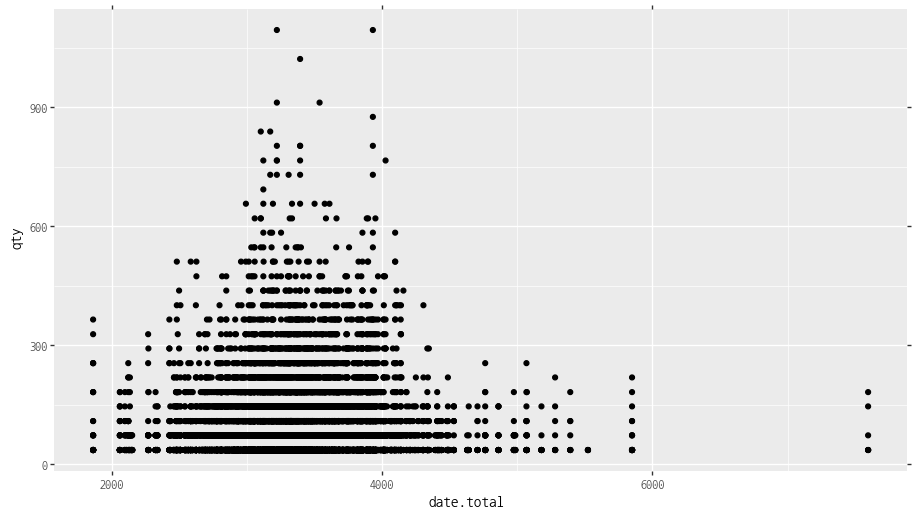

<ggplot: (118794854734)>

In [9]:
(ggplot(dws_lavla.loc[dws_lavla['category']=='제모제'])
+ aes(x='date.total', y='qty')
+ geom_point()
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (11,6))
)

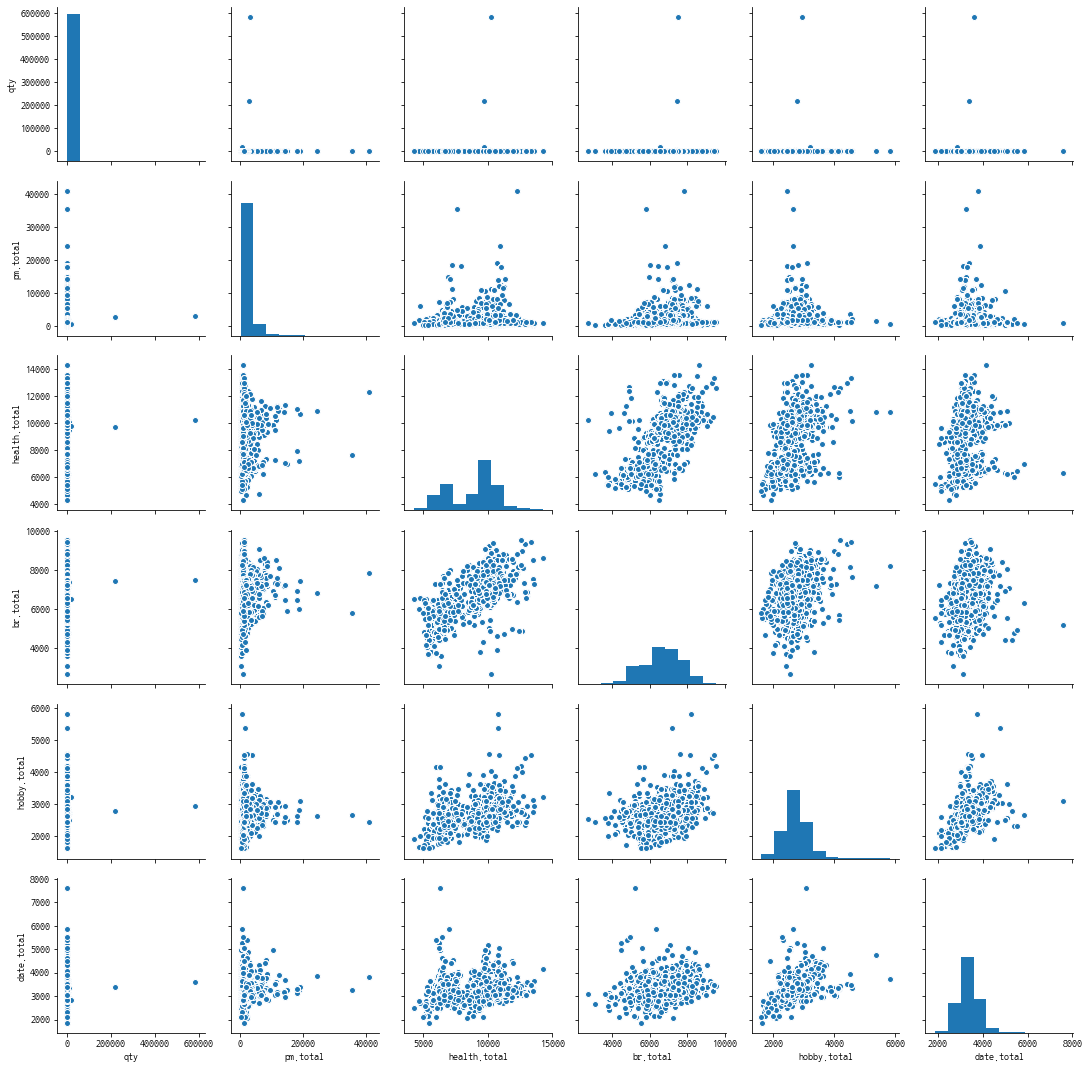

In [10]:
sns_cols = ['qty','pm.total', 'health.total','br.total', 'hobby.total','date.total']
sample = dws_lavla.loc[dws_lavla['category']=='바디로션',sns_cols]
sns.pairplot(sample[sns_cols])


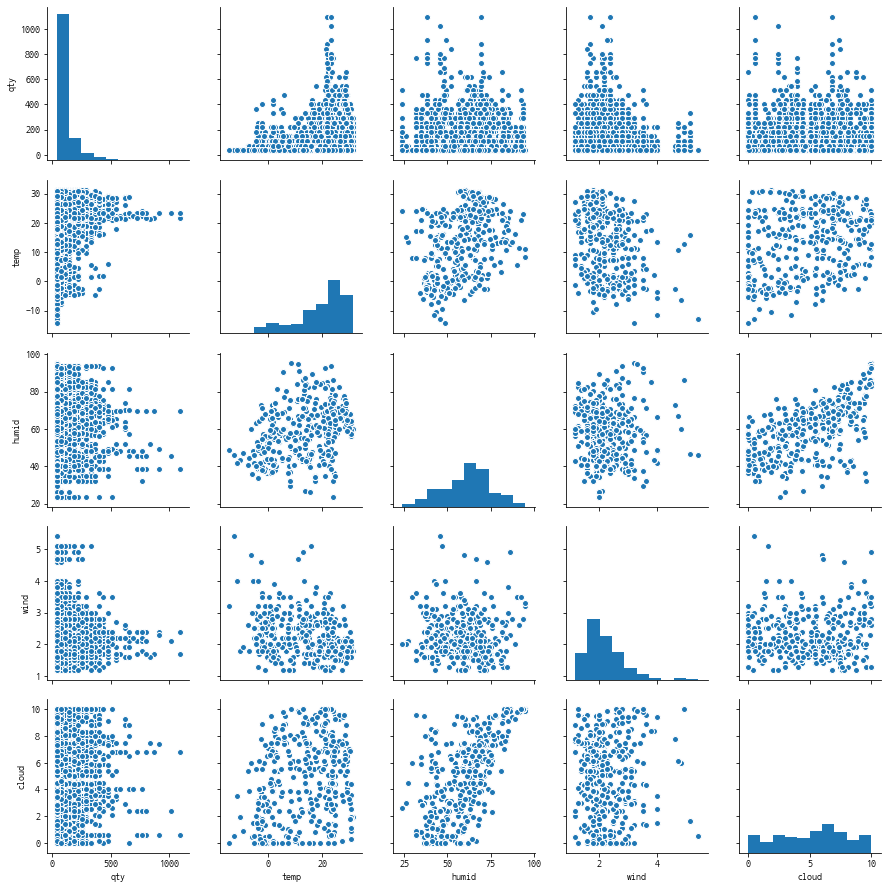

In [11]:
w_cols = ['qty', 'temp', 'humid', 'wind','cloud']
sample = dws_lavla.loc[(dws_lavla['category']=='제모제')&(dws_lavla['date']<='2016-12-31'),w_cols]
sns.pairplot(sample[w_cols])

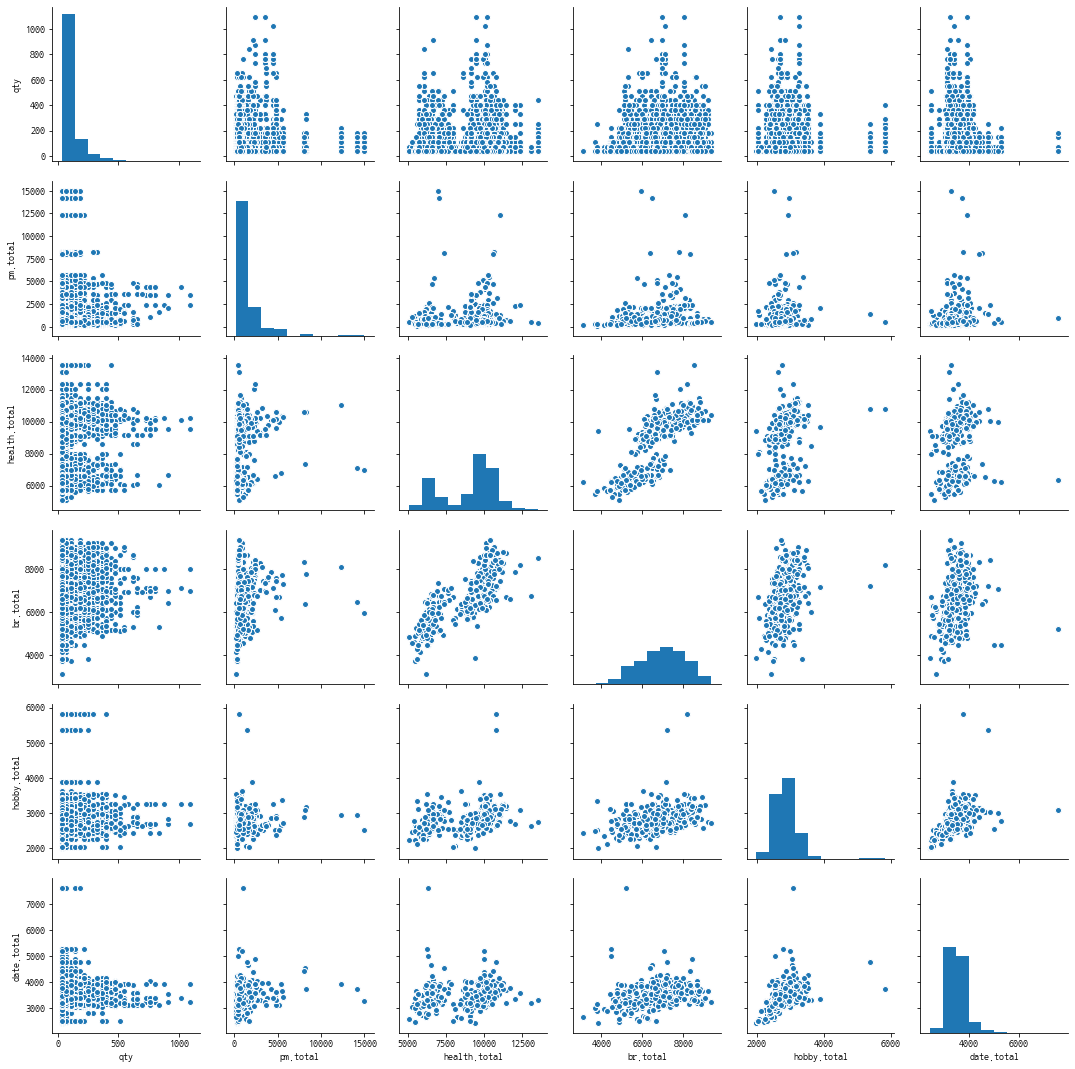

In [12]:
sns_cols = ['qty','pm.total', 'health.total','br.total', 'hobby.total','date.total']
sample = dws_lavla.loc[(dws_lavla['category']=='제모제')&(dws_lavla['date']<='2016-12-31'),sns_cols]
sns.pairplot(sample[sns_cols])

In [13]:
d_working = d_lavla[['date','qty','category']].groupby(by=['date','category']).sum().reset_index()
# d_working.head(10)
dw_working = pd.merge(d_working, w_seoul, on='date',how='left')
dws_working = dw_working.copy()

for df in collections:
    dws_working = pd.merge(dws_working, df, on='date',how='left')

dws_working.columns

Index(['date', 'category', 'qty', 'temp', 'humid', 'wind', 'rain', 'snow',
       'cloud', 'sun_time', 'pm.blog', 'pm.twitter', 'pm.news', 'pm.total',
       'health.blog', 'health.twitter', 'health.news', 'health.total',
       'date.blog', 'date.twitter', 'date.news', 'date.total', 'br.blog',
       'br.twitter', 'br.news', 'br.total', 'hobby.blog', 'hobby.twitter',
       'hobby.news', 'hobby.total'],
      dtype='object')

In [14]:
# lavla분석 선형
for item in lavla_category:
    linReg(dws_working,item)

LinearRegression을 이용한 립컬러의 회귀분석 결과 :
훈련세트점수 : 0.08
검증세트점수 : 0.01
LinearRegression을 이용한 립케어의 회귀분석 결과 :
훈련세트점수 : 0.39
검증세트점수 : 0.39
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.00
LinearRegression을 이용한 바디로션의 회귀분석 결과 :
훈련세트점수 : 0.34
검증세트점수 : -0.01
LinearRegression을 이용한 체중조절의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : -0.08
LinearRegression을 이용한 크림로션의 회귀분석 결과 :
훈련세트점수 : 0.05
검증세트점수 : 0.03
LinearRegression을 이용한 훼이셜클렌저의 회귀분석 결과 :
훈련세트점수 : 0.06
검증세트점수 : 0.03
LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
LinearRegression을 이용한 네일의 회귀분석 결과 :
훈련세트점수 : 0.37
검증세트점수 : 0.32
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.54
검증세트점수 : 0.54


In [15]:
for item in lavla_category:
    ridgeReg(dws_working,item)

RidgeRegression을 이용한 립컬러의 회귀분석 결과 :
훈련세트점수 : 0.07
검증세트점수 : 0.02
RidgeRegression을 이용한 립케어의 회귀분석 결과 :
훈련세트점수 : 0.39
검증세트점수 : 0.38
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : 0.00
RidgeRegression을 이용한 바디로션의 회귀분석 결과 :
훈련세트점수 : 0.33
검증세트점수 : -0.00
RidgeRegression을 이용한 체중조절의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.05
RidgeRegression을 이용한 크림로션의 회귀분석 결과 :
훈련세트점수 : 0.05
검증세트점수 : 0.03
RidgeRegression을 이용한 훼이셜클렌저의 회귀분석 결과 :
훈련세트점수 : 0.05
검증세트점수 : 0.04
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.42
검증세트점수 : 0.46
RidgeRegression을 이용한 네일의 회귀분석 결과 :
훈련세트점수 : 0.37
검증세트점수 : 0.33
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.53
검증세트점수 : 0.54


In [16]:
for item in lavla_category:
    lassoReg(dws_working,item)

LassoRegression을 이용한 립컬러의 회귀분석 결과 :
훈련세트점수 : 0.08
검증세트점수 : 0.01
사용한 특성수 : 12
LassoRegression을 이용한 립케어의 회귀분석 결과 :
훈련세트점수 : 0.39
검증세트점수 : 0.39
사용한 특성수 : 12
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.00
사용한 특성수 : 12
LassoRegression을 이용한 바디로션의 회귀분석 결과 :
훈련세트점수 : 0.34
검증세트점수 : -0.01
사용한 특성수 : 12
LassoRegression을 이용한 체중조절의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : -0.08
사용한 특성수 : 12
LassoRegression을 이용한 크림로션의 회귀분석 결과 :
훈련세트점수 : 0.05
검증세트점수 : 0.03
사용한 특성수 : 12
LassoRegression을 이용한 훼이셜클렌저의 회귀분석 결과 :
훈련세트점수 : 0.06
검증세트점수 : 0.03
사용한 특성수 : 12
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
사용한 특성수 : 12
LassoRegression을 이용한 네일의 회귀분석 결과 :
훈련세트점수 : 0.37
검증세트점수 : 0.32
사용한 특성수 : 12
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.54
검증세트점수 : 0.54
사용한 특성수 : 12


In [17]:
# lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
# # print(lasso)

# #점수
# print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
# print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

# #사용한 특성수
# print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )

In [18]:
# 제모제 2016~2018
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_working.loc[dws_working['category']=='제모제',col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm', 'health','br', 'hobby','date']
# model = formula_gen(3,Xy)
#  + 'pm.total' + 'health.total' + 'br.total' + 'hobby.total' + 'date.total'
model = sm.OLS.from_formula("qty ~ temp + sun_time + pm + health + br + hobby + date", data=Xy)
# model = sm.OLS.from_formula("qty ~ sun_time + pm + br + hobby + date", data=Xy)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     180.5
Date:                Wed, 10 Jul 2019   Prob (F-statistic):          4.85e-177
Time:                        18:21:26   Log-Likelihood:                -8893.3
No. Observations:                1094   AIC:                         1.780e+04
Df Residuals:                    1086   BIC:                         1.784e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5634.6637    343.799    -16.389      0.0

In [19]:
#제모제 2016-06-01~2016-10-01
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_working.loc[(dws_working['category']=='제모제')
                     &(dws_working['date'].between('2016-06-01','2016-10-01')),
                     col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
# model = formula_gen(3,Xy)
# model = sm.OLS.from_formula("qty ~ temp + I(temp**2) + date_total + I(date_total**2)", data=Xy)
model = sm.OLS.from_formula("qty ~ sun_time + pm_total + br_total + hobby_total + date_total", data=Xy)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     20.47
Date:                Wed, 10 Jul 2019   Prob (F-statistic):           1.22e-14
Time:                        18:21:27   Log-Likelihood:                -1054.5
No. Observations:                 123   AIC:                             2121.
Df Residuals:                     117   BIC:                             2138.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.265e+04   2156.942     -5.867      

In [20]:
# 체중조절 2016-06-01~2016-10-01
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_working.loc[(dws_working['category']=='체중조절'), col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
# model = sm.OLS.from_formula("qty ~ temp + I(temp**2) + date_total + I(date_total**2)", data=Xy)
# func = "qty ~ temp + sun_time + pm_total + br_total + hobby_total + date_total + health_total"
func = "qty ~ pm_total + br_total + hobby_total + date_total + health_total"
model = sm.OLS.from_formula(func, data=Xy)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.177
Date:                Wed, 10 Jul 2019   Prob (F-statistic):             0.0545
Time:                        18:21:29   Log-Likelihood:                -10114.
No. Observations:                1096   AIC:                         2.024e+04
Df Residuals:                    1090   BIC:                         2.027e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      449.0496    658.121      0.682   

['립컬러', '립케어', '마스크팩', '바디로션', '체중조절', '크림로션', '훼이셜클렌저', '선케어', '네일', '제모제']

# 마스크 분석/미세먼지(혹은 다른 것들)와의 상관 관계

In [21]:
# gs - 마스크/미세먼지와 상관 관계
d_gs_working = d_gs[['date','qty','category']].groupby(by=['date','category']).sum().reset_index()
# d_working.head(10)
dw_gs_working = pd.merge(d_gs_working, w_seoul, on='date',how='left')
dws_gs_working = dw_gs_working.copy()

for df in collections:
    dws_gs_working = pd.merge(dws_gs_working, df, on='date',how='left')

dws_gs_working.columns

Index(['date', 'category', 'qty', 'temp', 'humid', 'wind', 'rain', 'snow',
       'cloud', 'sun_time', 'pm.blog', 'pm.twitter', 'pm.news', 'pm.total',
       'health.blog', 'health.twitter', 'health.news', 'health.total',
       'date.blog', 'date.twitter', 'date.news', 'date.total', 'br.blog',
       'br.twitter', 'br.news', 'br.total', 'hobby.blog', 'hobby.twitter',
       'hobby.news', 'hobby.total'],
      dtype='object')

In [22]:
# 마스크 분석
col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
X = dws_gs_working.loc[dws_gs_working['category']=='마스크',col_to_use]
y = dws_gs_working.loc[dws_gs_working['category']=='마스크','qty']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(X_test, y_test)

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
print(ridge)

print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
print(lasso)

#점수
print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

#사용한 특성수
print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
훈련세트점수 : 0.79
검증세트점수 : 0.80
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=0, solver='auto', tol=0.001)
훈련세트점수 : 0.78
검증세트점수 : 0.76
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
훈련세트점수 : 0.79
검증세트점수 : 0.80
사용한 특성수 : 12


In [23]:
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_gs_working.loc[(dws_gs_working['category']=='마스크'), col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
# model = sm.OLS.from_formula("qty ~ temp + I(temp**2) + date_total + I(date_total**2)", data=Xy)
# func = "qty ~ temp + sun_time + pm_total + br_total + hobby_total + date_total + health_total"
func = "qty ~ pm_total + br_total + date_total + health_total"
model = sm.OLS.from_formula(func, data=Xy)

print(model.fit().summary())
print(model.fit().summary2())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     830.8
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:21:37   Log-Likelihood:                -8128.1
No. Observations:                1096   AIC:                         1.627e+04
Df Residuals:                    1091   BIC:                         1.629e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      655.7296    104.823      6.256   

In [24]:
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_gs_working.loc[(dws_gs_working['category']=='마스크'), col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

func = "qty ~ pm_total + I(pm_total**2) + I(pm_total**3)"
# func = "qty ~ pm_total + br_total + date_total + health_total"

model = sm.OLS.from_formula(func, data=Xy)

print(model.fit().summary())
print(model.fit().summary2())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1204.
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:21:37   Log-Likelihood:                -8093.8
No. Observations:                1096   AIC:                         1.620e+04
Df Residuals:                    1092   BIC:                         1.622e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          246.5203     19.694  

#### 우산

In [25]:
col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
X = dws_gs_working.loc[dws_gs_working['category']=='우산',col_to_use]
y = dws_gs_working.loc[dws_gs_working['category']=='우산','qty']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(X_test, y_test)

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
훈련세트점수 : 0.37
검증세트점수 : 0.27


In [26]:
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_gs_working.loc[(dws_gs_working['category']=='우산'), col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

# func = "qty ~ pm_total + I(pm_total**2) + I(pm_total**3)"
# func = "qty ~ temp + rain + snow + pm_total + br_total + date_total + health_total"
func = "qty ~ temp + rain + snow"

model = sm.OLS.from_formula(func, data=Xy)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     75.71
Date:                Wed, 10 Jul 2019   Prob (F-statistic):           7.72e-44
Time:                        18:21:39   Log-Likelihood:                -8526.2
No. Observations:                 938   AIC:                         1.706e+04
Df Residuals:                     934   BIC:                         1.708e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    667.2709    122.642      5.441      0.0

#### 맥주

In [27]:
col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
# col_to_use = ['temp','humid'
#              ,'health.total','br.total', 'hobby.total','date.total']
X = dws_gs_working.loc[dws_gs_working['category']=='맥주',col_to_use]
y = dws_gs_working.loc[dws_gs_working['category']=='맥주','qty']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(X_test, y_test)

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
훈련세트점수 : 0.61
검증세트점수 : 0.55


In [28]:
ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
print(ridge)

print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=0, solver='auto', tol=0.001)
훈련세트점수 : 0.60
검증세트점수 : 0.55


In [29]:
lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
print(lasso)

#점수
print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

#사용한 특성수
print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
훈련세트점수 : 0.61
검증세트점수 : 0.55
사용한 특성수 : 12


In [30]:
col_to_use = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
Xy = dws_gs_working.loc[(dws_gs_working['category']=='맥주'), col_to_use]
Xy.columns = ['qty','temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

# func = "qty ~ pm_total + I(pm_total**2) + I(pm_total**3)"
# func = "qty ~ temp + rain + snow + pm_total + br_total + date_total + health_total"
func = "qty ~ temp + + pm_total + br_total + date_total + health_total"

# func = "qty ~ temp + rain + snow"

model = sm.OLS.from_formula(func, data=Xy)

print(model.fit().summary())
print(model.fit().summary2())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     307.3
Date:                Wed, 10 Jul 2019   Prob (F-statistic):          2.97e-205
Time:                        18:21:41   Log-Likelihood:                -9632.5
No. Observations:                1096   AIC:                         1.928e+04
Df Residuals:                    1090   BIC:                         1.931e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.513e+04    413.966     36.546   

In [31]:
# gs 분석 한꺼번에
for item in gs_category:
    linReg(dws_gs_working, item)
    ridgeReg(dws_gs_working, item)
    lassoReg(dws_gs_working, item)
    print('  ')

LinearRegression을 이용한 라면의 회귀분석 결과 :
훈련세트점수 : 0.23
검증세트점수 : 0.18
RidgeRegression을 이용한 라면의 회귀분석 결과 :
훈련세트점수 : 0.23
검증세트점수 : 0.18
LassoRegression을 이용한 라면의 회귀분석 결과 :
훈련세트점수 : 0.23
검증세트점수 : 0.18
사용한 특성수 : 12
  
LinearRegression을 이용한 과자의 회귀분석 결과 :
훈련세트점수 : 0.45
검증세트점수 : 0.41
RidgeRegression을 이용한 과자의 회귀분석 결과 :
훈련세트점수 : 0.44
검증세트점수 : 0.41
LassoRegression을 이용한 과자의 회귀분석 결과 :
훈련세트점수 : 0.45
검증세트점수 : 0.41
사용한 특성수 : 12
  
LinearRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.79
검증세트점수 : 0.80
RidgeRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.78
검증세트점수 : 0.76
LassoRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.79
검증세트점수 : 0.80
사용한 특성수 : 12
  
LinearRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.61
검증세트점수 : 0.55
RidgeRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.60
검증세트점수 : 0.55
LassoRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.61
검증세트점수 : 0.55
사용한 특성수 : 12
  
LinearRegression을 이용한 생리대의 회귀분석 결과 :
훈련세트점수 : 0.28
검증세트점수 : 0.21
RidgeRegression을 이용한 생리대의 회귀분석 결과 :
훈련세트점수 : 0.28
검증세트점수 : 0.21
LassoRegression을 이용한 생리대의 회귀분석 결과 :
훈련세트점수 :